## Predictive Modeling


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import RidgeClassifier, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV

In [ ]:
file_path = "../data/preprocessed/pokemon_preprocessed.csv"
df = pd.read_csv(file_path)
df.info()

In [3]:
results = []

In [4]:
df.select_dtypes(include=['object']).columns

Index(['abilities', 'classfication', 'japanese_name', 'name', 'type1', 'type2',
       'legendary_status', 'xp_growth_rate', 'type_combo',
       'xp_growth_rate_from_diff', 'strength_difficulty_group'],
      dtype='object')

In [5]:
df["xp_growth_rate"].value_counts()

xp_growth_rate
Medium      335
Slow        202
Stalling    172
Fast         56
Erratic      22
Sluggish     14
Name: count, dtype: int64

In [6]:
df.drop(["abilities", "classfication", "japanese_name", "name", "legendary_status", "type_combo", "strength_difficulty_group", "xp_growth_rate_from_diff"], axis=1, inplace=True)

d### A. Predicting Legendary Status
- Classification using stats, type, generation
- Models: Logistic Regression, Random Forest, XGBoost

---

In [7]:
X = df.drop(columns=["is_legendary"])
y = df["is_legendary"]

In [8]:
ohe_cols = ["type1", "type2"]
ord_cols = ["xp_growth_rate"]

In [9]:
xp_order = ["Sluggish", "Stalling", "Slow", "Medium", "Fast", "Erratic"]

In [10]:
numeric_cols = [c for c in X.columns if c not in ohe_cols + ord_cols]

In [11]:
preprocess = ColumnTransformer(
    transformers=[
        ("type_ohe", OneHotEncoder(handle_unknown="ignore"), ohe_cols),
        ("xp_ord", OrdinalEncoder(categories=[xp_order]), ord_cols),
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_cols),
    ],
    remainder="drop"
)

In [12]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [13]:
rf_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(class_weight="balanced", random_state=42))
])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [15]:
scores = cross_validate(
    rf_pipe, X_train, y_train,
    cv=cv,
    scoring=["accuracy", "f1", "roc_auc", "average_precision"],
    return_train_score=True
)

In [16]:
scores

{'fit_time': array([0.16204119, 0.1597743 , 0.16363692, 0.1474371 , 0.17841578]),
 'score_time': array([0.04702258, 0.02917409, 0.0293541 , 0.03182292, 0.03446198]),
 'test_accuracy': array([0.9921875, 0.984375 , 0.984375 , 0.984375 , 0.9765625]),
 'train_accuracy': array([1., 1., 1., 1., 1.]),
 'test_f1': array([0.95652174, 0.9       , 0.9       , 0.91666667, 0.85714286]),
 'train_f1': array([1., 1., 1., 1., 1.]),
 'test_roc_auc': array([0.999223 , 1.       , 1.       , 0.9965035, 1.       ]),
 'train_roc_auc': array([1., 1., 1., 1., 1.]),
 'test_average_precision': array([0.99242424, 1.        , 1.        , 0.96177156, 1.        ]),
 'train_average_precision': array([1., 1., 1., 1., 1.])}

In [17]:
param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [5, 10, None],
    "model__min_samples_split": [2, 5],
    "model__class_weight": ["balanced"]
}

In [18]:
grid = GridSearchCV(
    estimator=rf_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="f1",
    n_jobs=-1
)

In [19]:
grid.fit(X_train, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'model__class_weight': ['balanced'], 'model__max_depth': [5, 10, ...], 'model__min_samples_split': [2, 5], 'model__n_estimators': [100, 200]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'f1'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : 

In [20]:
print("Best parameters:", grid.best_params_)
print("Best CV F1:", grid.best_score_)

Best parameters: {'model__class_weight': 'balanced', 'model__max_depth': 5, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Best CV F1: 0.9365424430641822


In [21]:
y_pred = grid.predict(X_test)

In [22]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[147   0]
 [  0  14]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       147
           1       1.00      1.00      1.00        14

    accuracy                           1.00       161
   macro avg       1.00      1.00      1.00       161
weighted avg       1.00      1.00      1.00       161



In [23]:
best_pipe = grid.best_estimator_
rf_model = best_pipe.named_steps["model"]

In [24]:
feature_names = best_pipe.named_steps["preprocess"].get_feature_names_out()

In [25]:
importances = rf_model.feature_importances_

In [26]:
importance_df = (
    pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    })
    .sort_values("Importance", ascending=False)
)

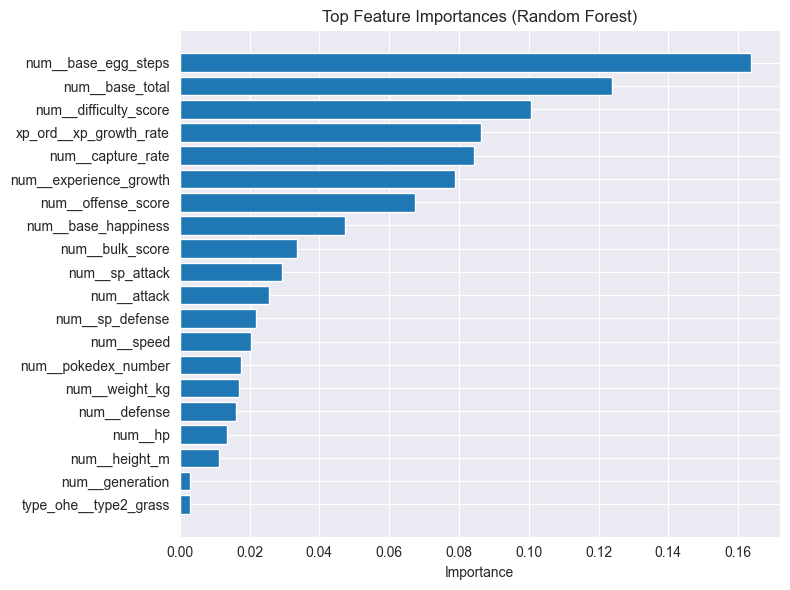

In [27]:
top_n = 20
plt.figure(figsize=(8, 6))
plt.barh(
    importance_df.head(top_n)["Feature"],
    importance_df.head(top_n)["Importance"]
)
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Top Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

# Ridge Classification

In [28]:
ridge_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RidgeClassifier(class_weight = "balanced", random_state=42))
])

In [29]:
param_grid = {
    "model__alpha": [0.001, 0.01, 0.1, 1, 10, 100],
}

In [30]:
grid = GridSearchCV(
    estimator=ridge_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="f1",
    n_jobs=-1
)

In [31]:
grid.fit(X_train, y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'model__alpha': [0.001, 0.01, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'f1'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displayed

In [32]:
print("Best parameters:", grid.best_params_)
print("Best CV F1:", grid.best_score_)

Best parameters: {'model__alpha': 100}
Best CV F1: 0.8962870462870463


In [33]:
y_pred = grid.predict(X_test)

In [34]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[146   1]
 [  0  14]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       147
           1       0.93      1.00      0.97        14

    accuracy                           0.99       161
   macro avg       0.97      1.00      0.98       161
weighted avg       0.99      0.99      0.99       161



# SGDClassifier

In [35]:
SGD_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", SGDClassifier(max_iter = 100, tol=1e-3, random_state=42))
])

In [36]:
param_grid = {
    "model__loss": ["log_loss"],
    "model__penalty": ["l2", "elasticnet"],
    "model__alpha": [1e-5, 1e-4, 1e-3, 1e-2],
    "model__l1_ratio": [0.15, 0.5],
    "model__learning_rate": ["optimal", "adaptive"],
    "model__eta0": [0.01, 0.1],
}

In [37]:
grid = GridSearchCV(
    estimator=SGD_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="f1",
    n_jobs=-1
)

In [38]:
grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)
print("Best CV F1:", grid.best_score_)

Best parameters: {'model__alpha': 0.01, 'model__eta0': 0.01, 'model__l1_ratio': 0.5, 'model__learning_rate': 'adaptive', 'model__loss': 'log_loss', 'model__penalty': 'elasticnet'}
Best CV F1: 0.9165424430641822


In [39]:
y_pred = grid.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[146   1]
 [  2  12]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       147
           1       0.92      0.86      0.89        14

    accuracy                           0.98       161
   macro avg       0.95      0.93      0.94       161
weighted avg       0.98      0.98      0.98       161



# K-neighbors classifier

In [40]:
kneighbors_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", KNeighborsClassifier(n_neighbors=5))
])

In [41]:
param_grid = {
    "model__n_neighbors": [3, 5, 7, 9, 11, 15, 21, 31],
    "model__weights": ["uniform", "distance"],
    "model__metric": ["minkowski"],
    "model__p": [1, 2],
    "model__leaf_size": [20, 30, 40],
}

In [42]:
grid = GridSearchCV(
    estimator=kneighbors_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="f1",
    n_jobs=-1
)

In [43]:
grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)
print("Best CV F1:", grid.best_score_)

Best parameters: {'model__leaf_size': 20, 'model__metric': 'minkowski', 'model__n_neighbors': 3, 'model__p': 2, 'model__weights': 'uniform'}
Best CV F1: 0.8387385129490392


In [44]:
y_pred = grid.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[147   0]
 [  5   9]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       147
           1       1.00      0.64      0.78        14

    accuracy                           0.97       161
   macro avg       0.98      0.82      0.88       161
weighted avg       0.97      0.97      0.97       161



# XGBoost Classifier

In [45]:
xgb_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=15, random_state=42))
])

In [46]:
param_grid = {
    "model__n_estimators": [50, 100, 200],
    "model__max_depth": [3, 5, 7],
    "model__learning_rate": [0.01, 0.1, 0.3],
    "model__scale_pos_weight": [10, 15],
}

In [47]:
grid = GridSearchCV(
    estimator=xgb_pipe,
    param_grid=param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

In [48]:
grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)
print("Best CV F1:", grid.best_score_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 200, 'model__scale_pos_weight': 10}
Best CV F1: 0.9651138716356108


C:\Users\Owner\PycharmProjects\pokemon-analysis\.venv1\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:20:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [49]:
y_pred = grid.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[147   0]
 [  0  14]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       147
           1       1.00      1.00      1.00        14

    accuracy                           1.00       161
   macro avg       1.00      1.00      1.00       161
weighted avg       1.00      1.00      1.00       161



In [50]:
from sklearn.linear_model import LogisticRegression

stack = StackingClassifier(
    estimators=[
        ("rf", RandomForestClassifier(class_weight="balanced", random_state=42)),
        ("gb", GradientBoostingClassifier(random_state=42)),
        ("sgd", SGDClassifier(class_weight="balanced", random_state=42)),
        ("knn", KNeighborsClassifier()),
    ],
    final_estimator=LogisticRegression(class_weight="balanced", max_iter=2000, random_state=42),
    passthrough=True,
    cv=5,
    n_jobs=-1
)

In [51]:
stack_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", stack)
])

In [52]:
param_grid = {
    "model__passthrough": [True, False],

    # Meta-model tuning
    "model__final_estimator__C": [0.1, 1, 10],
    "model__final_estimator__penalty": ["l2"],
    "model__final_estimator__solver": ["lbfgs"],

    "model__rf__n_estimators": [200, 500],
    "model__rf__max_depth": [None, 10],

    "model__knn__n_neighbors": [5, 11, 21],
    "model__knn__weights": ["uniform", "distance"],
}

In [53]:
grid = GridSearchCV(
    estimator=stack_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="f1",
    n_jobs=-1
)
grid.fit(X_train, y_train)

C:\Users\Owner\PycharmProjects\pokemon-analysis\.venv1\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...rough=True))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'model__final_estimator__C': [0.1, 1, ...], 'model__final_estimator__penalty': ['l2'], 'model__final_estimator__solver': ['lbfgs'], 'model__knn__n_neighbors': [5, 11, ...], ...}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'f1'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo... shuffle=True)
,"verbose verbose: intControls the verbosity: t

In [54]:
print("Best parameters:", grid.best_params_)
print("Best CV F1:", grid.best_score_)

Best parameters: {'model__final_estimator__C': 10, 'model__final_estimator__penalty': 'l2', 'model__final_estimator__solver': 'lbfgs', 'model__knn__n_neighbors': 11, 'model__knn__weights': 'uniform', 'model__passthrough': False, 'model__rf__max_depth': None, 'model__rf__n_estimators': 200}
Best CV F1: 0.9395987201204592


In [55]:
y_pred = grid.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[147   0]
 [  0  14]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       147
           1       1.00      1.00      1.00        14

    accuracy                           1.00       161
   macro avg       1.00      1.00      1.00       161
weighted avg       1.00      1.00      1.00       161



# Voting Classifier

In [56]:
voting = VotingClassifier(
    estimators=[
        ("rf", RandomForestClassifier(class_weight="balanced", random_state=42)),
        ("gb", GradientBoostingClassifier(random_state=42)),
        ("sgd", SGDClassifier(loss="log_loss", class_weight="balanced", random_state=42)),
        ("knn", KNeighborsClassifier()),
        ("xgb", XGBClassifier(
            eval_metric="logloss",
            scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
            random_state=42
        )),
    ],
    voting="hard",   # <-- safest
    n_jobs=-1
)

In [59]:
voting_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", voting)
])

In [60]:
voting_pipe.fit(X_train, y_train)
y_pred = voting_pipe.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[147   0]
 [  1  13]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       147
           1       1.00      0.93      0.96        14

    accuracy                           0.99       161
   macro avg       1.00      0.96      0.98       161
weighted avg       0.99      0.99      0.99       161

